# WordCloud

In [1]:
import gensim
from sklearn.externals import joblib
from os import path
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from random import shuffle

In [10]:
%%time


def get_topic_wordclouds(model_name, n_topics):

    ldamodel = joblib.load(model_name)

    terms = []
    ## word lists
    for i in range(0, n_topics):
        temp = ldamodel.show_topic(i, 50)
        for term in temp:
            terms.append(term)
        # print ("Top 10 terms for topic #" + str(i) + ": "+ ", ".join([i[0] for i in terms]))
#     print (terms)    
    return terms





CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


In [11]:
%%time 


## word clouds
n_topics = 16
model_name = 'data/eos/lda/16_LDAmodel_EOS.pkl'

def terms_to_wordcounts(terms, multiplier=10000):
    term_wordcount = " ".join([" ".join(int(multiplier*i[1]) * [i[0]]) for i in terms])
    t = term_wordcount.split(" ")
    shuffle(t)
    return " ".join(t)

def generate_wordcloud():
    terms = get_topic_wordclouds(model_name, n_topics)
    wordcloud = WordCloud(max_font_size=40, background_color="black")
    print(terms_to_wordcounts(terms))
    wordcloud.generate(terms_to_wordcounts(terms))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("data/eos/wordcloud.png", dpi=1000)
    plt.close()
    

generate_wordcloud()

just oil iran accord hold first 5 turkish people international people beijing daily_mail und content global can like continue şi study story win can care protest turkish meeting world iran_amid new tell report region right play werbung company two police investment add start kill istanbul point intelligence first hong_kong start turkey dead site dass oil charge well die death financial water detainee turkey goal second tell four one people die country leader kill 2014 make state work take million thing percent accord five facebook dubai comment prime_minister one iraq look state last technique report cia work somers week two erdoğan_pay korkie visit price can militant istanbul iran hong_kong president isil may see kill company 2014 2014 city think victory bush day report night well turkey day comment coalition two program city das statement add give security play home like weapon win man ferguson 2014 also case al use die december week committee turkey turkey council know world police_

CPU times: user 4.86 s, sys: 40 ms, total: 4.9 s
Wall time: 4.92 s


(16, 3198)
(16, 3198)


<IPython.core.display.Javascript object>


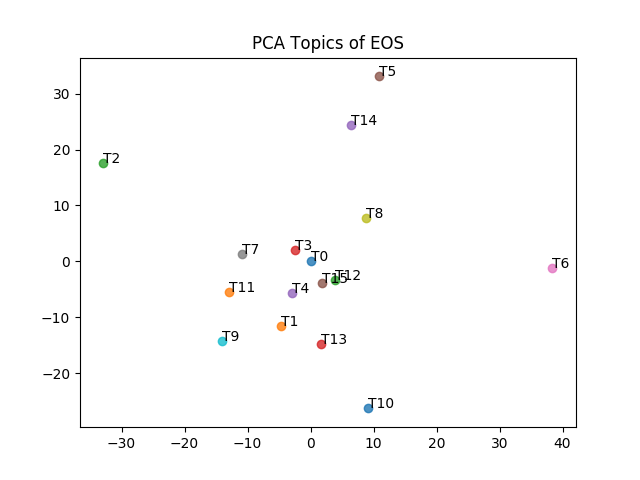

CPU times: user 900 ms, sys: 460 ms, total: 1.36 s
Wall time: 877 ms


In [88]:
%%time

%matplotlib notebook
from scipy import stats

# Different PCA

## topic-words vectors: topics vs. words
from sklearn.feature_extraction import DictVectorizer

def topics_to_vectorspace(model_name, n_topics, n_words=200):
    rows = []
    ldamodel = joblib.load(model_name)
    for i in range(n_topics):
        temp = ldamodel.show_topic(i, n_words)
        row = dict(((i[1],i[0]) for i in temp))
        rows.append(row)

    return rows    

vec = DictVectorizer()

X = vec.fit_transform(topics_to_vectorspace(model_name, n_topics))
print (X.shape)
topics_data_norm = stats.zscore(X.toarray(), axis=0)
print(topics_data_norm.shape)

## PCA
from sklearn.decomposition import PCA

colors = ['navy', 'turquoise', 'darkorange']

pca = PCA(n_components=6)

X_pca = pca.fit(topics_data_norm).transform(topics_data_norm)

plt.figure()
for i in range(X_pca.shape[0]):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], alpha=.8, 
                label='topic%d' % i)
    plt.text(X_pca[i, 0], X_pca[i, 1], s='T' + str(i))    
    
# plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA Topics of EOS')
# plt.savefig("data/eos/pca_topic.png", dpi=1000)

# plt.close()

In [13]:
%%time

## hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram

plt.figure(figsize=(12,6))
R = dendrogram(linkage(X_pca))
plt.savefig("data/eos/dendro.png", dpi=1000)

plt.close()

CPU times: user 3.06 s, sys: 300 ms, total: 3.36 s
Wall time: 3.05 s


In [14]:
%%time


## correlation matrix
from scipy.spatial.distance import pdist, squareform

cor = squareform(pdist(X.toarray(), metric="euclidean"))

plt.figure(figsize=(12,6))
R = dendrogram(linkage(cor))
plt.savefig("data/eos/corr.png", dpi=1000)

plt.close()


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if __name__ == '__main__':


CPU times: user 3.02 s, sys: 312 ms, total: 3.34 s
Wall time: 3 s


In [59]:
%%time


## network
import networkx as nx

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

pca_norm = make_pipeline(PCA(n_components=20), Normalizer(copy=False))

X_pca_norm = pca_norm.fit(X.toarray()).transform(X.toarray())

cor = squareform(pdist(X_pca_norm, metric="euclidean"))

G = nx.Graph()

for i in range(cor.shape[0]):
    for j in range(cor.shape[1]):
        if i == j:
            G.add_edge(i, j, {"weight":0})
        else:
            G.add_edge(i, j, {"weight":1.0/cor[i,j]})

edges = [(i, j) for i, j, w in G.edges(data=True) if w['weight'] > .8]
edge_weight=dict([((u,v,),int(d['weight'])) for u,v,d in G.edges(data=True)])

#pos = nx.graphviz_layout(G, prog="twopi") # twopi, neato, circo
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=100, alpha=.5)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=1)
#nx.draw_networkx_edge_labels(G, pos ,edge_labels=edge_weight)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

plt.savefig("network")

plt.close()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


OverflowError: cannot convert float infinity to integer